In [2]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class DuelingDeepQNetwork(keras.Model):
    def __init__(self, n_actions, fc1_dims, fc2_dims):
        super(DuelingDeepQNetwork, self).__init__()
        self.dense1 = keras.layers.Dense(fc1_dims, activation='relu')
        self.dense2 = keras.layers.Dense(fc2_dims, activation='relu')
        self.V = keras.layers.Dense(1, activation=None)
        self.A = keras.layers.Dense(n_actions, activation=None)

    def call(self, state):
        x = self.dense1(state)
        x = self.dense2(x)
        V = self.V(x)
        A = self.A(x)

        Q = (V + (A - tf.math.reduce_mean(A, axis=1, keepdims=True)))

        return Q

    def advantage(self, state):
        x = self.dense1(state)
        x = self.dense2(x)
        A = self.A(x)

        return A

In [4]:
class ReplayBuffer():
    def __init__(self, max_size, input_shape):
        self.mem_size = max_size
        self.mem_cntr = 0

        self.state_memory = np.zeros((self.mem_size, *input_shape),
                                        dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_shape),
                                        dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done

        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace=False)

        states = self.state_memory[batch]
        new_states = self.new_state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        dones = self.terminal_memory[batch]

        return states, actions, rewards, new_states, dones

In [5]:
class Agent():
    def __init__(self, lr, gamma, n_actions, epsilon, batch_size,
                 input_dims, epsilon_dec=1e-3, eps_end=0.01, 
                 mem_size=100000, fname='dueling_dqn.h5', fc1_dims=128,
                 fc2_dims=128, replace=100):
        self.action_space = [i for i in range(n_actions)]
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_dec = epsilon_dec
        self.eps_min = eps_end
        self.fname = fname
        self.replace = replace
        self.batch_size = batch_size

        self.learn_step_counter = 0
        self.memory = ReplayBuffer(mem_size, input_dims)
        self.q_eval = DuelingDeepQNetwork(n_actions, fc1_dims, fc2_dims)
        self.q_next = DuelingDeepQNetwork(n_actions, fc1_dims, fc2_dims)

        self.q_eval.compile(optimizer=Adam(learning_rate=lr),
                            loss='mean_squared_error')
        self.q_next.compile(optimizer=Adam(learning_rate=lr),
                            loss='mean_squared_error')

    def store_transition(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def choose_action(self, observation):
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            state = np.array([observation])
            actions = self.q_eval.advantage(state)
            action = tf.math.argmax(actions, axis=1).numpy()[0]

        return action

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return

        if self.learn_step_counter % self.replace == 0:
            self.q_next.set_weights(self.q_eval.get_weights())

        states, actions, rewards, states_, dones = \
                                    self.memory.sample_buffer(self.batch_size)

        q_pred = self.q_eval(states)
        q_next = tf.math.reduce_max(self.q_next(states_), axis=1, keepdims=True).numpy()
        q_target = np.copy(q_pred)

        for idx, terminal in enumerate(dones):
            if terminal:
                q_next[idx] = 0.0
            q_target[idx, actions[idx]] = rewards[idx] + self.gamma*q_next[idx]

        self.q_eval.train_on_batch(states, q_target)

        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > \
                        self.eps_min else self.eps_min

        self.learn_step_counter += 1

    def save_model(self):
        self.q_eval.save(self.model_file)

    def load_model(self):
        self.q_eval = load_model(self.model_file)

In [6]:
def plotLearning(x, scores, epsilons, filename, lines=None):
    fig=plt.figure()
    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(x, epsilons, color="C0")
    ax.set_xlabel("Game", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
	    running_avg[t] = np.mean(scores[max(0, t-20):(t+1)])

    ax2.scatter(x, running_avg, color="C1")
    #ax2.xaxis.tick_top()
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    #ax2.set_xlabel('x label 2', color="C1")
    ax2.set_ylabel('Score', color="C1")
    #ax2.xaxis.set_label_position('top')
    ax2.yaxis.set_label_position('right')
    #ax2.tick_params(axis='x', colors="C1")
    ax2.tick_params(axis='y', colors="C1")

    if lines is not None:
        for line in lines:
            plt.axvline(x=line)

    plt.savefig(filename)

In [7]:
!pip3 install box2d-py
!pip3 install gym[Box_2D]
import gym

     |████████████████████████████████| 448 kB 4.8 MB/s 


episode  0 score -101.4 average score -101.4 epsilon 0.98
episode  1 score -116.5 average score -109.0 epsilon 0.89
episode  2 score -259.1 average score -159.0 epsilon 0.78
episode  3 score -34.2 average score -127.8 epsilon 0.71
episode  4 score -465.5 average score -195.4 epsilon 0.59
episode  5 score -385.7 average score -227.1 epsilon 0.48
episode  6 score -208.6 average score -224.4 epsilon 0.34
episode  7 score -60.1 average score -203.9 epsilon 0.29
episode  8 score -365.3 average score -221.8 epsilon 0.20
episode  9 score -221.9 average score -221.8 epsilon 0.10
episode  10 score -71.0 average score -208.1 epsilon 0.01
episode  11 score -311.5 average score -216.7 epsilon 0.01
episode  12 score -211.9 average score -216.4 epsilon 0.01
episode  13 score -47.4 average score -204.3 epsilon 0.01
episode  14 score -68.0 average score -195.2 epsilon 0.01
episode  15 score -298.4 average score -201.7 epsilon 0.01
episode  16 score -61.7 average score -193.4 epsilon 0.01
episode  17 s

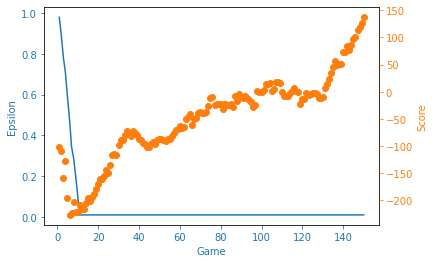

In [9]:
if __name__ == '__main__':
    env = gym.make('LunarLander-v2')
    n_games = 150
    agent = Agent(gamma=0.99, epsilon=1, lr=1e-3, input_dims=[8], 
                  epsilon_dec=1e-3, mem_size=100000, batch_size=64, eps_end=0.01,
                  fc1_dims=128, fc2_dims=128, replace=100, n_actions=4)

    scores, eps_history = [], []

    for i in range(n_games):
        done = False
        score = 0
        observation = env.reset()
        while not done:
            action = agent.choose_action(observation)
            observation_, reward, done, info = env.step(action)
            score += reward
            agent.store_transition(observation, action, reward, observation_, done)
            observation = observation_
            agent.learn()
        eps_history.append(agent.epsilon)
        scores.append(score)

        avg_score = np.mean(scores[-100:])
        print('episode ', i, 'score %.1f' % score,
                'average score %.1f' % avg_score,
                'epsilon %.2f' % agent.epsilon)

    filename='keras_lunar_lander.png'
    x = [i+1 for i in range(n_games)]
    plotLearning(x, scores, eps_history, filename)
